# Flatiron School: Use your regression skills to save the Galaxy

### InClass prediction Competition

### 1. Obtaining the Data

In [83]:
# import libraries 
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [84]:
df = pd.read_csv('train.csv')
df.shape

(11703, 13)

In [85]:
df.head()

,Id,NA_Sales,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,0.00,PSP,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E
1,1,0.72,2600,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.11,XB,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.15,X360,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T
4,4,0.00,DS,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
len(df[df['JP_Sales'] == 0.00])

7340

In [87]:
len(df[df['NA_Sales'] == 0.00])

3193

In [88]:
df.duplicated().sum()

0

In [89]:
df = df.drop(['Id', 'Publisher', 'JP_Sales', 'Critic_Count', 'User_Count', 'Developer', 'Rating'], axis=1)
df.head()

,NA_Sales,Platform,Year_of_Release,Genre,Critic_Score,User_Score
0,0.00,PSP,2008.0,Misc,81.0,8.3
1,0.72,2600,1982.0,Shooter,NaN,NaN
2,0.11,XB,2004.0,Action,NaN,NaN
3,0.15,X360,2008.0,Fighting,54.0,6.3
4,0.00,DS,2006.0,Action,NaN,NaN


### 2. Preprocessing the Data

**2.1. Dropping Records with missing values**

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Critic_Score       5697 non-null float64
User_Score         7011 non-null object
dtypes: float64(3), object(3)
memory usage: 548.7+ KB


In [17]:
# handling NaN records in genre_column
df = df.dropna(axis=0, subset=['Year_of_Release', 'Genre'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11518 non-null float64
Platform           11518 non-null object
Year_of_Release    11518 non-null float64
Genre              11518 non-null object
Critic_Score       5597 non-null float64
User_Score         6893 non-null object
dtypes: float64(3), object(3)
memory usage: 629.9+ KB


**2.2. Handling `Platform` column**

In [18]:
df.Platform.unique()

array(['PSP', '2600', 'XB', 'X360', 'DS', 'PS2', 'Wii', 'PS3', '3DS',
       'PS', 'XOne', 'SNES', 'WiiU', 'GBA', 'PS4', 'PC', 'PSV', 'SAT',
       'GC', 'NES', 'N64', 'GEN', 'PCFX', 'GB', 'DC', 'TG16', 'NG', 'SCD',
       'WS', '3DO', 'GG'], dtype=object)

In [19]:
# check Platform_column for main platforms and create interim columns
df['Nintendo']    = df['Platform'].str.contains('DS', regex=True)
df['Playstation'] = df['Platform'].str.contains('PS', regex=True)
df['X_Box']       = df['Platform'].str.contains('X(\d|\w)', regex=True)
df['Wii']         = df['Platform'].str.contains('Wii', regex=True)
df['PC']          = df['Platform'].str.contains('PC', regex=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [20]:
# define function ...
def label_platform(row):
    if row['Nintendo'] == True:
        return 'Nintendo'
    if row['Playstation'] == True:
        return 'Playstation'
    if row['X_Box'] == True:
        return 'X_Box'
    if row['Wii'] == True:
        return 'Wii'
    if row['PC'] == True:
        return 'PC'
    return 'Other'

# ... and apply this function for creating a new column
df['platform_groups'] = df.apply(lambda row: label_platform(row), axis=1)

# dropping interim columns
df = df.drop(['Platform', 'Nintendo', 'Playstation', 'X_Box', 'Wii', 'PC'], axis=1)

df.head()

,NA_Sales,Year_of_Release,Genre,Critic_Score,User_Score,platform_groups
0,0.00,2008.0,Misc,81.0,8.3,Playstation
1,0.72,1982.0,Shooter,NaN,NaN,Other
2,0.11,2004.0,Action,NaN,NaN,X_Box
3,0.15,2008.0,Fighting,54.0,6.3,X_Box
4,0.00,2006.0,Action,NaN,NaN,Nintendo


**2.4. Handling `Year_of_release` column**

In [21]:
df['Year_of_Release'] = df['Year_of_Release'].astype('int64')
df['Year_of_Release'] = pd.to_datetime(df['Year_of_Release'], format="%Y").dt.year

In [22]:
df.head()

,NA_Sales,Year_of_Release,Genre,Critic_Score,User_Score,platform_groups
0,0.00,2008,Misc,81.0,8.3,Playstation
1,0.72,1982,Shooter,NaN,NaN,Other
2,0.11,2004,Action,NaN,NaN,X_Box
3,0.15,2008,Fighting,54.0,6.3,X_Box
4,0.00,2006,Action,NaN,NaN,Nintendo


In [23]:
#df.Year_of_Release.value_counts()

In [24]:
#df.drop(df[df.Year_of_Release < 2000].index, axis=0, inplace=True)
#df.Year_of_Release.value_counts()

**2.3. Handling `User_Score` column**

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11518 non-null float64
Year_of_Release    11518 non-null int64
Genre              11518 non-null object
Critic_Score       5597 non-null float64
User_Score         6893 non-null object
platform_groups    11518 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 629.9+ KB


In [26]:
df.User_Score.unique()

array(['8.3', nan, '6.3', 'tbd', '7.7', '2.8', '8.2', '9', '4.3', '7.2',
       '8.5', '7.6', '7.5', '8.1', '6.1', '7', '6.7', '7.4', '7.9', '5.4',
       '7.8', '5.2', '8.6', '4', '5', '8.7', '6.8', '4.1', '6.4', '6.6',
       '9.3', '7.3', '5.7', '4.2', '2.7', '3.8', '3', '8', '6.2', '8.8',
       '4.4', '7.1', '3.6', '5.5', '4.5', '8.4', '5.9', '6', '5.3', '0.5',
       '8.9', '6.5', '3.2', '9.1', '5.8', '5.6', '4.9', '6.9', '2.4',
       '9.5', '3.7', '3.3', '3.9', '2.6', '2.9', '9.2', '1.8', '4.6',
       '3.4', '4.8', '4.7', '5.1', '9.4', '3.1', '2.5', '3.5', '2.2',
       '2.1', '1.9', '9.7', '1.4', '1.7', '0', '0.3', '1.5', '1', '9.6',
       '1.6', '1.2', '0.9', '0.7', '0.6', '2', '2.3', '1.3', '0.2'],
      dtype=object)

In [27]:
len(df[df['User_Score'] == 'tbd'])

1646

In [28]:
# replace 'tbd'
df['User_Score'].replace(to_replace='tbd', value=np.nan, inplace=True)

# convert string values into numeric values
df['User_Score'] = pd.to_numeric(df['User_Score'])

df.User_Score.describe()

count    5247.000000
mean        7.126739
std         1.489370
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: User_Score, dtype: float64

Let's keep this distribution in mind: The max value is 9.7, the 0.75 percentile is 8.2!

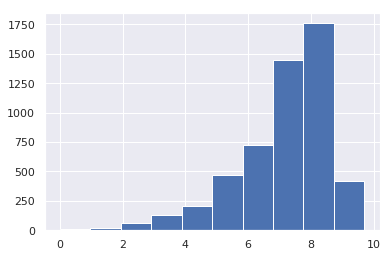

In [29]:
df.User_Score.hist();

In [30]:
# How many NaN's are we up against?
round(df['User_Score'].isna().sum()/len(df), 3)

0.544

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11518 non-null float64
Year_of_Release    11518 non-null int64
Genre              11518 non-null object
Critic_Score       5597 non-null float64
User_Score         5247 non-null float64
platform_groups    11518 non-null object
dtypes: float64(3), int64(1), object(2)
memory usage: 629.9+ KB


In [40]:
# filter out sub_df to work with
sub_df = df[['NA_Sales', 'Year_of_Release', 'User_Score']]

# convert string values in into categorical values
#sub_df['Genre'] = sub_df['Genre'].astype('category')
#sub_df['platform_groups'] = sub_df['platform_groups'].astype('category')

In [42]:
# split datasets
train_data = sub_df[sub_df['User_Score'].notnull()]
test_data  = sub_df[sub_df['User_Score'].isnull()]

# define X for both datasets
X_train = train_data.drop('User_Score', axis=1)
X_test  = test_data.drop('User_Score', axis=1)

# define y for train dataset
y_train = train_data['User_Score']

# create dummy variables of all categorical features
#X_train = pd.get_dummies(X_train)

print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (5247, 3)
Shape of Test Data:     (6271, 3)

Shape of X_train: (5247, 2)
Shape of X_test: (6271, 2)

Shape of y_train: (5247,)


In [43]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

# making predictions
y_test = linreg.predict(X_test)

In [44]:
# preparing y_test
y_test = pd.DataFrame(y_test)
y_test.columns = ['User_Score']
print(y_test.shape)
y_test.head(2)

(6271, 1)


,User_Score
0,9.53449
1,7.43993


In [45]:
# preparing X_test
print(X_test.shape)
X_test.head(2)

(6271, 2)


,NA_Sales,Year_of_Release
1,0.72,1982
2,0.11,2004


In [46]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

# finally combine the new test data
test_data = pd.concat([X_test, y_test], axis=1)

In [47]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head(2)

(11518, 3)


,NA_Sales,Year_of_Release,User_Score
1,0.72,1982,9.53449
2,0.11,2004,7.43993


In [48]:
sub_df_new['User_Score'].isna().sum()

0

In [49]:
sub_df_new.User_Score.describe()

count    11518.000000
mean         7.221710
std          1.113615
min          0.000000
25%          6.790309
50%          7.243559
75%          7.945330
max         12.355242
Name: User_Score, dtype: float64

In [50]:
sub_df_new.drop(sub_df_new[ (sub_df_new['User_Score'] > 9.7) ].index, 
                axis=0, inplace=True)

sub_df_new.User_Score.describe()

count    11506.000000
mean         7.218577
std          1.109679
min          0.000000
25%          6.790309
50%          7.243559
75%          7.933317
max          9.700000
Name: User_Score, dtype: float64

In [51]:
# drop duplicate columns in original dataframe before concatening 
df = df.drop(['NA_Sales', 'Year_of_Release', 'User_Score'], axis=1)

# concatenate back to complete dataframe
df = pd.concat([sub_df_new, df], axis=1)

print(df.shape)
df.head(2)

(11518, 6)


,NA_Sales,Year_of_Release,User_Score,Genre,Critic_Score,platform_groups
0,0.00,2008.0,8.30000,Misc,81.0,Playstation
1,0.72,1982.0,9.53449,Shooter,NaN,Other


In [52]:
#df = df.drop(['User_Count'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11506 non-null float64
Year_of_Release    11506 non-null float64
User_Score         11506 non-null float64
Genre              11518 non-null object
Critic_Score       5597 non-null float64
platform_groups    11518 non-null object
dtypes: float64(4), object(2)
memory usage: 629.9+ KB


In [53]:
df = df.dropna(axis=0, subset=['NA_Sales', 'Year_of_Release', 'User_Score'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11506 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11506 non-null float64
Year_of_Release    11506 non-null float64
User_Score         11506 non-null float64
Genre              11506 non-null object
Critic_Score       5597 non-null float64
platform_groups    11506 non-null object
dtypes: float64(4), object(2)
memory usage: 629.2+ KB


**2.3. Handling `Critic_Score` column**

In [54]:
# How many NaN's are we up against?
round(df['Critic_Score'].isna().sum()/len(df), 3)

0.514

In [55]:
df.Critic_Score.describe()

count    5597.000000
mean       68.915133
std        14.045524
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: Critic_Score, dtype: float64

Let's not forget the max: 98 as well as the 0.75 percentile: 79!

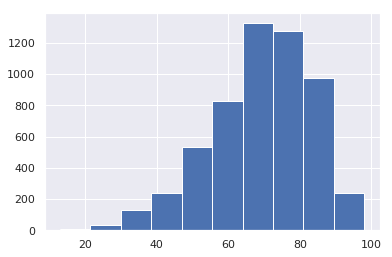

In [56]:
df.Critic_Score.hist();

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11506 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11506 non-null float64
Year_of_Release    11506 non-null float64
User_Score         11506 non-null float64
Genre              11506 non-null object
Critic_Score       5597 non-null float64
platform_groups    11506 non-null object
dtypes: float64(4), object(2)
memory usage: 629.2+ KB


In [58]:
# filter out sub_df to work with
sub_df = df[['NA_Sales', 'Year_of_Release', 'User_Score', 'Critic_Score']]

In [59]:
# split datasets
train_data = sub_df[sub_df['Critic_Score'].notnull()]
test_data  = sub_df[sub_df['Critic_Score'].isnull()]

# define X for both datasets
X_train = train_data.drop('Critic_Score', axis=1)
X_test  = test_data.drop('Critic_Score', axis=1)

# define y for train dataset
y_train = train_data['Critic_Score']

print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (5597, 4)
Shape of Test Data:     (5909, 4)

Shape of X_train: (5597, 3)
Shape of X_test: (5909, 3)

Shape of y_train: (5597,)


In [60]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

# making predictions
y_test = linreg.predict(X_test)

In [61]:
# preparing y_test
y_test = pd.DataFrame(y_test)
y_test.columns = ['Critic_Score']
print(y_test.shape)
y_test.head(2)

(5909, 1)


,Critic_Score
0,69.777012
1,67.850237


In [62]:
# preparing X_test
print(X_test.shape)
X_test.head(2)

(5909, 3)


,NA_Sales,Year_of_Release,User_Score
1,0.72,1982.0,9.53449
2,0.11,2004.0,7.43993


In [63]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

# finally combine the new test data
test_data = pd.concat([X_test, y_test], axis=1)

In [64]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head(2)

(11506, 4)


,NA_Sales,Year_of_Release,User_Score,Critic_Score
1,0.72,1982.0,9.53449,69.777012
2,0.11,2004.0,7.43993,67.850237


In [65]:
sub_df_new['Critic_Score'].isna().sum()

0

In [66]:
# drop duplicate columns in original dataframe before concatening 
df = df.drop(['NA_Sales', 'Year_of_Release', 'User_Score', 'Critic_Score'], axis=1)

# concatenate back to complete dataframe
df = pd.concat([sub_df_new, df], axis=1)

print(df.shape)
df.head(2)

(11506, 6)


,NA_Sales,Year_of_Release,User_Score,Critic_Score,Genre,platform_groups
0,0.00,2008.0,8.30000,81.000000,Misc,Playstation
1,0.72,1982.0,9.53449,69.777012,Shooter,Other


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11506 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11506 non-null float64
Year_of_Release    11506 non-null float64
User_Score         11506 non-null float64
Critic_Score       11506 non-null float64
Genre              11506 non-null object
platform_groups    11506 non-null object
dtypes: float64(4), object(2)
memory usage: 629.2+ KB


**2.5. Handling `Rating` column**

In [166]:
#df.Rating.value_counts()

In [167]:
#df.drop(df[df.Rating == 'RP'].index, axis=0, inplace=True)
#df.Rating.value_counts()

## 3. Machine Learning

*Preparing Target & Features*

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11506 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11506 non-null float64
Year_of_Release    11506 non-null float64
User_Score         11506 non-null float64
Critic_Score       11506 non-null float64
Genre              11506 non-null object
platform_groups    11506 non-null object
dtypes: float64(4), object(2)
memory usage: 629.2+ KB


In [69]:
# define our features 
features = df.drop(["NA_Sales"], axis=1)

# define our target
target = df[["NA_Sales"]]

*Recoding Categorical Features*

In [70]:
# convert string values in object columns into categorical values
df['Genre'] = df['Genre'].astype('category')
#df['Rating'] = df['Rating'].astype('category')
df['platform_groups'] = df['platform_groups'].astype('category')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11506 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11506 non-null float64
Year_of_Release    11506 non-null float64
User_Score         11506 non-null float64
Critic_Score       11506 non-null float64
Genre              11506 non-null category
platform_groups    11506 non-null category
dtypes: category(2), float64(4)
memory usage: 472.5 KB


In [72]:
# create dummy variables of all categorical features
features = pd.get_dummies(features)

*Train-Test-Split*

In [73]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

*Scaling the Data*

In [74]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


*XGBoost*

In [75]:
# create a baseline
booster = xgb.XGBRegressor()

In [79]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 1, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [80]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=1, gamma=0.2, learning_rate=0.05, 
                           max_depth=3, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test  = booster.predict(X_test)

In [81]:
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

RMSE: 0.507
r2: 0.3528


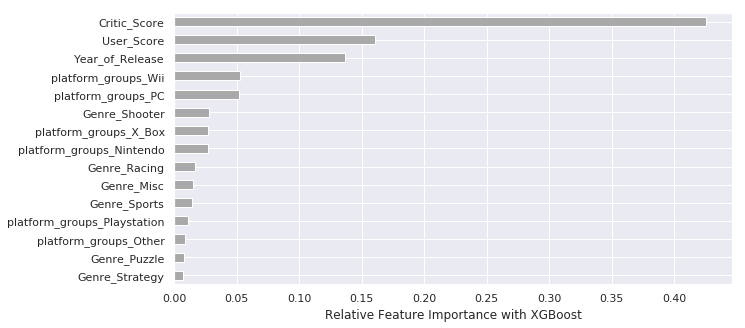

In [82]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');